<a href="https://colab.research.google.com/github/spdrnl/ecg/blob/master/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

# Move data from Drive to /tmp

In [18]:
from google.colab import drive
drive.mount("/tmp/drive")
! unzip "/tmp/drive/My Drive/data/29414_37484_bundle_archive.zip" -d /tmp/ecg
! ls /tmp/ecg

Drive already mounted at /tmp/drive; to attempt to forcibly remount, call drive.mount("/tmp/drive", force_remount=True).
Archive:  /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip
replace /tmp/ecg/mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /tmp/ecg/mitbih_test.csv  
  inflating: /tmp/ecg/mitbih_train.csv  
  inflating: /tmp/ecg/ptbdb_abnormal.csv  
  inflating: /tmp/ecg/ptbdb_normal.csv  
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Import and analyse data
## MIT-BIH Arrhythmia Dataset

In [113]:
mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)

In [ ]:
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train['labels'] = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)
mitbih_test['labels'] = mitbih_test.iloc[:,-1].replace(mitbih_reverse_labels)

In [128]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [143]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arrhythmia Dataset')

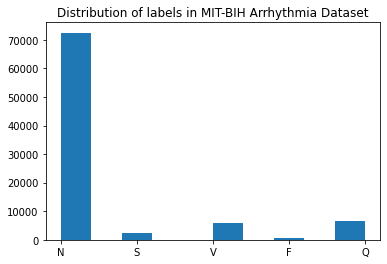

In [129]:
plt.hist(mitbih_train['labels'])
plt.title("Distribution of labels in MIT-BIH Arrhythmia Dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

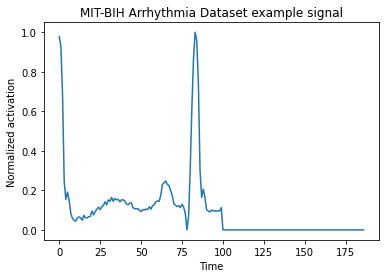

In [130]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

## PTB Diagnostic ECG Database

In [131]:
ptbdb_abnormal = pd.read_csv("/tmp/ecg/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("/tmp/ecg/ptbdb_normal.csv", header=None)

In [132]:
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)
ptbdb['labels'] = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

In [144]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [145]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'Distribution of the PTB Diagnostic ECG Database labels')

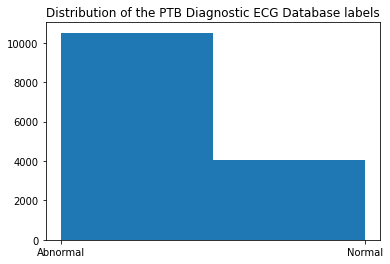

In [133]:
plt.hist(ptbdb['labels'], bins=2)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

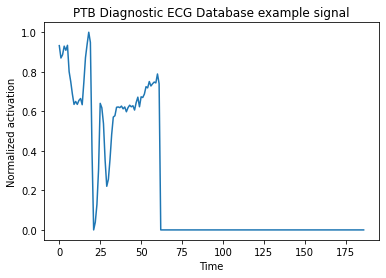

In [134]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

## Merging the datasets

In [137]:
print(ptbdb.shape)
print(mitbih_train.shape)
print(mitbih_test.shape)

(14552, 189)
(87554, 189)
(21892, 189)


In [199]:
X_mitbih_train = mitbih_train.iloc[:,:-2].values
y_mitbih_train = mitbih_train.iloc[:,-2].values

X_mitbih_test = mitbih_test.iloc[:,:-2].values
y_mitbih_test = mitbih_test.iloc[:,-2].values

X_ptbdb_train, X_ptbdb_test, y_ptbdb_train, y_ptbdb_test = train_test_split(ptbdb.iloc[:,:-2].values, ptbdb.iloc[:,-2].values, test_size=0.2, random_state=42)
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(X_ptbdb_train, y_ptbdb_train, test_size=0.2, random_state=42)

X_ptbdb_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdb_train = np.expand_dims(y_ptbdb_train, -1)
X_ptbdb_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdb_val = np.expand_dims(y_ptbdb_val, -1)

In [202]:
model = keras.Sequential([
  keras.layers.Conv1D(50,5,input_shape=[187,1]),
  keras.layers.Dense(100, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')                  
])

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), batch_size=128, epochs=50)

Epoch 1/50
73/73 [==============================] - 3s 44ms/step - loss: 0.6121 - accuracy: 0.7106 - val_loss: 0.5874 - val_accuracy: 0.7222
Epoch 2/50
73/73 [==============================] - 3s 41ms/step - loss: 0.5898 - accuracy: 0.7168 - val_loss: 0.5809 - val_accuracy: 0.7222
Epoch 3/50
73/73 [==============================] - 3s 41ms/step - loss: 0.5833 - accuracy: 0.7168 - val_loss: 0.5744 - val_accuracy: 0.7222
Epoch 4/50
73/73 [==============================] - 3s 43ms/step - loss: 0.5795 - accuracy: 0.7168 - val_loss: 0.5725 - val_accuracy: 0.7222
Epoch 5/50
73/73 [==============================] - 3s 42ms/step - loss: 0.5783 - accuracy: 0.7168 - val_loss: 0.5719 - val_accuracy: 0.7222
Epoch 6/50
73/73 [==============================] - 3s 43ms/step - loss: 0.5777 - accuracy: 0.7168 - val_loss: 0.5712 - val_accuracy: 0.7222
Epoch 7/50
73/73 [==============================] - 3s 42ms/step - loss: 0.5774 - accuracy: 0.7168 - val_loss: 0.5743 - val_accuracy: 0.7222
Epoch 8/50
73

KeyboardInterrupt: ignored

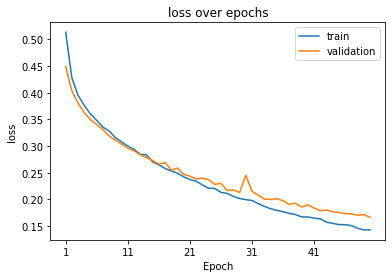

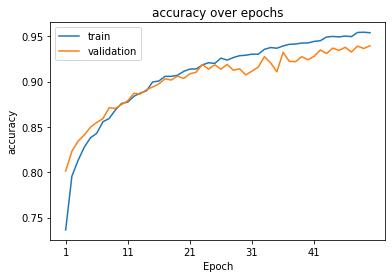

In [195]:
def pretty_plot(history, field):
  data = history.history[field]
  plt.plot(range(1, len(data)+1), data, label='train')
  data = history.history['val_'+field]
  plt.plot(range(1, len(data)+1), data, label='validation')
  plt.xlabel('Epoch')
  plt.ylabel(field)
  plt.xticks(range(1, len(data)+1, 10))
  plt.title("{} over epochs".format(field))
  plt.legend()
  plt.show()

pretty_plot(history, 'loss')
pretty_plot(history, 'accuracy')


In [211]:
def residual_block(X, kernels, stride):
  out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
  out = keras.layers.ReLU()(out)
  out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
  out = keras.layers.add([X, out])
  out = keras.layers.ReLU()(out)
  out = keras.layers.MaxPool1D(5, 2)(out)
  return out

kernels = 32
stride = 5
inputs = keras.layers.Input([187,1])
X = keras.layers.Conv1D(kernels, stride)(inputs)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = residual_block(X, kernels, stride)
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(32, activation='relu')(X)
X = keras.layers.Dense(32, activation='relu')(X)
output = keras.layers.Dense(1, activation='sigmoid')(X)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 183, 32)      192         input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 183, 32)      5152        conv1d_27[0][0]                  
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 183, 32)      0           conv1d_28[0][0]                  
____________________________________________________________________________________________

In [213]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), batch_size=128, epochs=5)

Epoch 1/5
73/73 [==============================] - 10s 143ms/step - loss: 0.0245 - accuracy: 0.9909 - val_loss: 0.0195 - val_accuracy: 0.9948
Epoch 2/5
73/73 [==============================] - 10s 133ms/step - loss: 0.0100 - accuracy: 0.9965 - val_loss: 0.0970 - val_accuracy: 0.9768
Epoch 3/5
73/73 [==============================] - 10s 133ms/step - loss: 0.0257 - accuracy: 0.9913 - val_loss: 0.0343 - val_accuracy: 0.9906
Epoch 4/5
73/73 [==============================] - 10s 133ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.1188 - val_accuracy: 0.9652
Epoch 5/5
73/73 [==============================] - 10s 133ms/step - loss: 0.0307 - accuracy: 0.9903 - val_loss: 0.0334 - val_accuracy: 0.9906


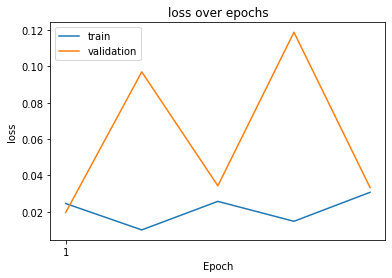

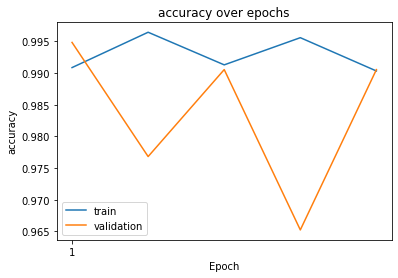

In [214]:
pretty_plot(history, 'loss')
pretty_plot(history, 'accuracy')